<a href="https://colab.research.google.com/github/himalayahall/DATA602/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

NLP (Natural Language Processing), NLU (Natural Language Understanding), and NLG (Natural Language Generation) are important subtopics of Machine 
Learning. 

**NLP** it involves programming computers to process massive volumes of language data. It involves numerous tasks that break down natural language into 
smaller elements in order to understand the relationships between those elements and how they work together. NLP focuses largely on converting text to 
structured data. It does this through the identification of named entities (a process called named entity recognition) and identification of word 
patterns, using methods like tokenization, stemming, and lemmatization, which examine the root forms of words.

**NLU** (Natural Language Understanding) is a subset of natural language processing, which uses syntactic and semantic analysis of text and speech to determine the meaning of a sentence. One of the primary goals of NLU is to teach machines how to interpret and understand language inputted by humans. 
It aims to teach computers what a body of text or spoken speech means. NLU leverages AI algorithms to recognize attributes of language such as sentiment, semantics, context, and intent. It enables computers to understand the subtleties and variations of language.

**NLG** (Natural Language Generation) is also a subset of NLP and is concerned with enabling machines to not just process and understand text but to generate text. While NLU focuses on computer reading comprehension, NLG enables computers to write. NLG is the process of producing a human language 
text response based on some data input (prompt).[[1]](#1)

## Project Goal

Recent advancements in NLP, most notable the NLG capabilities of Large Language Models (LLM) like ChatGPT, have taken the public imagination by storm. In this project we will explore the following:

- **NLP**: create a classifier to classify product reviews as either original (presumably human created and authentic) or fake (computer generated fake reviews). The motivation for using this dataset is that fake reviews are a major problem, as highlighted in the NPR article [Why we usually can't tell when a review is fake](https://www.npr.org/sections/money/2023/03/07/1160721021/why-we-usually-cant-tell-when-a-review-is-fake), and it would be great to leverage NLP to address the problem.
  - Use [Fastai](https://docs.fast.ai) to build the classifier. This will be accomplished by taking a pretrained language model and fine-tuning it to classify reviews.  What we call a language model is a model that has been trained to guess what the next word in a text is (having read the ones before). This kind of task is called self-supervised learning: we do not need to give labels to our model, just feed it lots and lots of texts. It has a process to automatically get labels from the data, and this task isn't trivial: to properly guess the next word in a sentence, the model will have to develop an understanding of the English (or other) language.[[2]](#2)
- **NLU**: the English learned by the pretrained language model (Wikipedia) is slightly different from the English used for product reviews, so instead of jumping directly to the classifier, we will fine-tune our pretrained language model to the product corpus and then use that as the base for our classifier. This should (hopefully) result in better performance.
- **NLG**: finally, having created a language model that has been fine-tuned for product reviews, we will use it to auto-generate fake reviews. This will be done by giving the model some starting text (prompt) and then asking the model to generate the rest (up to a maximum number of words).

## Data Sources

The generated [fake reviews dataset](https://osf.io/3vds7), containing 20k fake reviews and 20k real product reviews. OR = Original reviews (presumably human created and authentic); CG = Computer-generated fake reviews.

## Tools and Frameworks

- [Google Collab](https://colab.research.google.com)
- [Jupyter Notebook](https://jupyter.org/)
- [Fastai](https://docs.fast.ai)

## References
<a id="1">[1]</a>
https://www.ibm.com/topics/natural-language-processing

<a id="2">[2]</a>
https://fastai.github.io/fastbook2e/book10.html


# Load data

In [ ]:
import pandas as pd
import re

df = pd.read_csv('https://raw.githubusercontent.com/himalayahall/DATA607/main/Project4/EMAILSpamCollectionFull.csv')

In [ ]:
df.head()

,id,from,subject,category,text
0,1,robert elz <kre@munnari.oz.au>,re: new sequences window,ham,"Date: Wed, 21 Aug 2002 10:54:46 -0..."
1,2,steve burt <steve_burt@cursor-system.com>,[zzzzteana] re: alexander,ham,"Martin A posted:Tassos Papadopoulos, the Gree..."
2,3,"""tim chapman"" <timc@2ubh.com>",[zzzzteana] moscow bomber,ham,Man Threatens Explosion In Moscow Thursday Au...
3,4,monty solomon <monty@roscom.com>,[irr] klez: the virus that won't die,ham,Klez: The Virus That Won't Die Already the mo...
4,5,tony nugent <tony@linuxworks.com.au>,re: insert signature,ham,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wro..."


Drop all columns except text and category.

In [ ]:
df.drop(columns=['from', 'subject'], inplace=True)
df

,id,category,text
0,1,ham,"Date: Wed, 21 Aug 2002 10:54:46 -0..."
1,2,ham,"Martin A posted:Tassos Papadopoulos, the Gree..."
2,3,ham,Man Threatens Explosion In Moscow Thursday Au...
3,4,ham,Klez: The Virus That Won't Die Already the mo...
4,5,ham,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wro..."
...,...,...,...
9345,9346,spam,NaN
9346,9347,spam,NaN
9347,9348,spam,NaN
9348,9349,spam,NaN


In [ ]:
df.describe(include='object')

,category,text
count,9350,7953
unique,2,4618
top,ham,
freq,5553,84


# Cleanup Data

Drop NAs and strip HTML tags.

In [ ]:
df.dropna(inplace=True)
df['text'] = df['text'].str.replace('<[^<>]*>', ' ', regex=True)
print(df.head())
df.describe(include='object')

   id category                                               text
0   1      ham       Date:        Wed, 21 Aug 2002 10:54:46 -0...
1   2      ham   Martin A posted:Tassos Papadopoulos, the Gree...
2   3      ham   Man Threatens Explosion In Moscow Thursday Au...
3   4      ham   Klez: The Virus That Won't Die Already the mo...
4   5      ham   On Wed Aug 21 2002 at 15:46, Ulises Ponce wro...


,category,text
count,7953,7953
unique,2,4565
top,ham,
freq,5553,84


## Compute NULL model (baseline) accuracy

As expected, this dataset is unbalanced (more $ham$ than $spam$ observations) and the $null$ model has 70% accuracy. The $null$ model always predicts the majority class ($ham$) and is useless for detecting $spam$ emails.

As a result, we know that a model worth considering must have accuracy significantly greater than 70%.

In [ ]:
cat_size = df.groupby('category').size()
print(cat_size)

ham_prop = cat_size[0] / (cat_size[0] + cat_size[1])
print('Baseline (null model) accuracy: ' , ham_prop)

category
ham     5553
spam    2400
dtype: int64
Baseline (null model) accuracy:  0.6982270841192003


## Fastai

We will use the fastai framework to build a large language model (LLM). Fastai is a great framework that enables rapid creating of predictive models without the need to code lower level artifacts as in Tensorflow or PyTorch.

In [ ]:
from fastai.data.all import *
from fastai.text.all import *

Create data loaders for classification, build **DataBlock** using **TextBlock** and **CategoryBlock**.

Set aside 20% data using **TrainTestSplitter** for model testing.

In [ ]:
dls_cls = DataBlock(
            blocks=(
                TextBlock.from_df(text_cols=('text'), 
                        is_lm=False),
                CategoryBlock),
            get_x=ColReader('text'), 
            get_y=ColReader('category'),
            splitter=TrainTestSplitter(test_size=0.2,stratify=df.category)
        ).dataloaders(df)

In [ ]:
dls_cls.show_batch(max_n = 5)

,text,category
0,"xxbos xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart _ xxrep 3 0 _ xxrep 3 0 2_01c228ca.593b5280content - type : text / plain ; \t xxunk - xxunk - transfer - encoding : xxunk < xxunk xxrep 3 $ xxunk ! # xxunk ! # xxunk % / % xxunk , xxunk ! $ xxunk % / $ xxunk xxrep 3 $ xxunk , xxunk ! # xxunk : xxunk $ xxunk # ! xxunk xxrep 3 $ xxup xxunk / $ @$5$$ ! # ! xxunk / ! xxunk > xxunk $ / $ * 4j xxrep 5 $ ? $ 7$^$9 ! # xxunk xxrep 38 - + xxunk \ xxunk # % "" xxunk \ % xxunk # % xxunk ! e = xxunk xxunk - mail : xxunk : 03 - 3518 - xxunk",ham
1,"xxbos xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart _ xxrep 3 0 _ xxrep 3 0 2_01c228ca.593b5280content - type : text / plain ; \t xxunk - xxunk - transfer - encoding : xxunk < xxunk xxrep 3 $ xxunk ! # xxunk ! # xxunk % / % xxunk , xxunk ! $ xxunk % / $ xxunk xxrep 3 $ xxunk , xxunk ! # xxunk : xxunk $ xxunk # ! xxunk xxrep 3 $ xxup xxunk / $ @$5$$ ! # ! xxunk / ! xxunk > xxunk $ / $ * 4j xxrep 5 $ ? $ 7$^$9 ! # xxunk xxrep 38 - + xxunk \ xxunk # % "" xxunk \ % xxunk # % xxunk ! e = xxunk xxunk - mail : xxunk : 03 - 3518 - xxunk",ham
2,"xxbos "" free trade and free markets have proven their ability to lift xxunk out of xxunk not a socio - political / history buff - does anybody have some xxunk ? xxrep 5 - xxmaj original xxmaj message xxrep 5 - xxmaj from : "" rohit xxmaj khare "" xxmaj to : xxmaj sent : xxmaj friday , xxmaj september 20 , 2002 xxunk pmsubject : sed / s / xxmaj united xxmaj states / xxmaj roman xxmaj empire / g > > a world where some live in comfort and plenty , while half of the human > > race lives on less than $ 2 a day , is neither just nor stable . > > xxmaj absolutely correct . xxmaj perhaps the most fundamental thing to realize about > life on xxmaj earth today . > > xxmaj the following is a fascinating document of official",ham
3,"xxbos > a world where some live in comfort and plenty , while half of the human > race lives on less than $ 2 a day , is neither just nor xxunk correct . xxmaj perhaps the most fundamental thing to realize about life on xxmaj earth xxunk following is a fascinating document of official xxmaj government policy that bears close reading . xxmaj it is the aspirations of a wonderful nation in an imperfect world . > xxmaj the war on terrorism is not a clash of civilizations . xxmaj it does , > however , reveal the clash inside a civilization , a battle for the > future of the xxmaj muslim world . xxmaj this is a struggle of ideas and this is an > area where xxmaj america must xxunk was recently at a lecture about the surprising success of xxmaj radio xxmaj sawa ,",ham
4,"xxbos xxrep 3 - xxunk - type : text / plain ; charset = iso-8859 - 1your xxmaj membership xxmaj community & xxmaj commentary ( june 29 , 2001)it 's xxmaj all xxmaj about xxmaj making moneyinformation to provide you with the absolute best low and no cost ways of providing traffic to your site , helping you to capitalize on the power and potential the web brings to every net - preneur . xxrep 3 - xxmaj this xxmaj issue xxmaj contains xxmaj sites xxmaj who xxmaj will xxmaj trade xxmaj links xxmaj with xxmaj you ! xxrep 3 - xxrep 13 - xxup in xxup this xxup issue xxrep 13 - 32 xxmaj easy xxmaj ways xxmaj to xxmaj breath xxmaj new xxmaj life xxmaj into xxmaj any xxunk xxunk xxmaj you xxmaj ready xxmaj for xxmaj your 15 xxmaj minutes of xxunk a xxup free xxmaj ad",spam


## Text Classifier

Create classifier. Notice,  there is no need to  pre-process text data for the classifier, e.g. create word embeddings, the framework does that automatically.

Here we are using [AWD_LST]([https://arxiv.org/pdf/1708.02182.pdf]) (averaged weght-dropped long-short term memory) model architecture.

In [ ]:
learner = text_classifier_learner(dls_cls, 
                                    AWD_LSTM, 
                                    drop_mult=0.5, 
                                    metrics=[accuracy, Precision(), Recall(), F1Score()])

Calculate the optimal learning rate hyper-parameter. This will greatly influence how quickly the model converges.

SuggestedLRs(valley=0.004365158267319202)

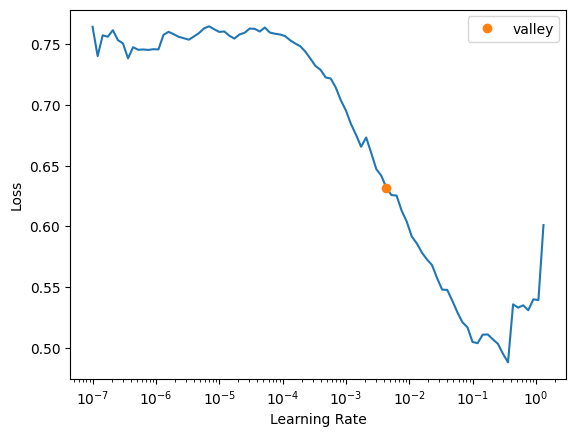

In [ ]:
lr = learner.lr_find()
lr

Fine tune model for 3 epochs using above learning rate.

In [ ]:
learner.fine_tune(3, lr[0])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.317265,0.189484,0.948460,0.909465,0.920833,0.915114,01:00


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.171857,0.131769,0.954745,0.901575,0.954167,0.927126,01:58
1,0.111063,0.076246,0.974859,0.948980,0.968750,0.958763,01:59
2,0.089614,0.068975,0.979887,0.960905,0.972917,0.966874,01:55


## Interpret results

F1-score (balanced score between Precision/Recall) is great and so are Precision/Recall. Most importantly, this model significantly outperforms the $null$ model.

Note - the model was tuned using GPUs, tuning on CPUs will take significantly longer (hours).

Show a few predictions on training data, the predictions are in the new _$category$ column.

In [ ]:
learner.show_results()

,text,category,category_
0,xxbos xxmaj this is a multi - part message in xxup mime format -- xxunk - xxunk - b6fa-0050ba415022content - type : text / plain ; charset = gb2312content - transfer - encoding : quoted - printable = cb = c4 = b4 = f3 = cb = d8 = d6 = ca = c5 = e0 = d1 = f8 = b4 = f2 = d4 = xxunk xxup mba = bd = cc = d3 = fd = b5 = c4 = cc = d8 = b5 = e3 = a3 = ac = d4 = da = cb = d8 = d6 = ca = c5 = e0 = d1 = f8 = xxunk = d7 = dc = ca = c7 = d2 = d4 = d3 = c5 = d0 = e3 = b9 = dc = c0 = ed = c8 = cb =,spam,spam
1,"xxbos xxmaj from : xxunk xxrep 5 s xxunk : \t\t\t\t\t xxmaj subject : xxmaj earn money sending e - mails . xxmaj it 's easy ! \t▁ xxup new xxup improved xxunk friend , you can earn a lot of money in the next 90 days sending xxunk impossible ? xxmaj is there a catch ? xxup no , there is no catch ; justsend your e - mails and be on your way to financial freedom . xxmaj basically , i send out as many of these e - mails as i can , xxunk send me cash in the mail for information that i just e - xxunk to them . xxmaj everyday , i make a three minute drive to my xxup p.o . xxmaj xxunk that there are at least a few hundred dollars waiting forme . xxmaj and the best part , xxup it",spam,spam
2,"xxbos xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart_7hzmysbwvsemnjin8kg9ycontent - type : multipart / alternative ; \t boundary= "" xxrep 4 - = _ nextpart_7hzmysbwvsemnjin8kg9yaa "" xxrep 6 - = _ xxunk - type : text / html ; \t charset=""big5""content - transfer - encoding : xxunk xxrep 6 - = _ nextpart_7hzmysbwvsemnjin8kg9yaa xxrep 8 - = _ nextpart_7hzmysbwvsemnjin8kg9ycontent - type : application / octet - stream ; \t name= "" . / massmail-1509_files / xxunk - transfer - encoding : base64content - disposition : attachment ; \t xxunk xxrep 4 a xxunk xxrep 4 a xxunk xxrep 4 a xxmaj xxunk xxrep 4 a xxunk xxrep 4 a xxunk xxrep 3 a xxmaj ox xxrep 3 a xxunk / xxunk / xxunk / xxunk / xxunk / xxunk / xxunk / xxunk / xxunk / xxunk / xxunk",spam,spam
3,"xxbos xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart _ xxrep 3 0 _ 01bc2b74.89d1 xxrep 3 c 0content - type : multipart / alternative ; \t boundary= "" xxrep 4 - = _ nextpart_84815c5abaf209ef376268c8 "" xxrep 6 - = _ nextpart_84815c5abaf209ef376268c8content - type : text / plain ; charset = windows-1252content - transfer - encoding : quoted - printabledear xxmaj sir / xxunk you a wonderful xxunk xxmaj with an offer , to save you money and xxunk xxmaj shopping from the convenience from home or xxunk shopping , a new way to go window xxunk xxmaj our online super xxunk offers over 1500 quality products , with 15 plus xxunk you to , window shop xxunk following are xxmaj e - coupons numbers , which you can use with any order=2e xxmaj y = ou place from",spam,spam
4,"xxbos xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart _ xxrep 3 0 _ 01bc2b74.89d1 xxrep 3 c 0content - type : multipart / alternative ; \t boundary= "" xxrep 4 - = _ nextpart_84815c5abaf209ef376268c8 "" xxrep 6 - = _ nextpart_84815c5abaf209ef376268c8content - type : text / plain ; charset = windows-1252content - transfer - encoding : quoted - printabledear xxmaj sir / xxunk you a wonderful xxunk xxmaj with an offer , to save you money and xxunk xxmaj shopping from the convenience from home or xxunk shopping , a new way to go window xxunk xxmaj our online super xxunk offers over 1500 quality products , with 15 plus xxunk you to , window shop xxunk following are xxmaj e - coupons numbers , which you can use with any order=2e xxmaj y = ou place from",spam,spam
5,"xxbos xxmaj this is a multi - part message in xxup mime format … xxrep 12 - = _ 1033046883 - 23957 - 4content - type : text / plain ; charset=""iso-8859 - 1""content - disposition : inlinecontent - transfer - encoding : 7bitto view this newsletter in full - color , visit : http : / / newsletter.mediaunspun.com / index xxrep 4 0 20868.cfmmedia unspunwhat the xxmaj press is

Plot confusion matrix to see detailed model performance. Note, the confusion matrix is generated using the test data (20% of training data).

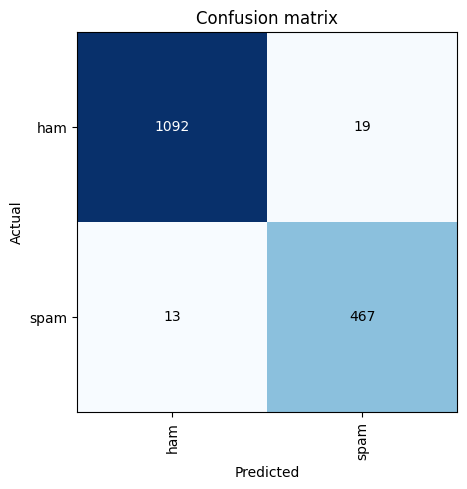

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

## Saving and loading model

At this point, if we wanted, we could save the model and it's trained weights. Later, the saved model could be loaded for making predictions.

In [ ]:
learner.save('pretrained')

Path('models/pretrained.pth')

In [ ]:
learner.load('pretrained')

# Language Model (ULMFiT approach)

The pretrained model in the previous section is called a language model. It was pretrained on Wikipedia on the task of guessing the next word, after reading all the words before. 

Notice, we are glossing over the details of exactly how many words are considered in making the prediction, what is the $loss function$, which $optimizer$ to use to fit the model, etc. Fastai selects intelligent defaults for all these paramaters are more.

We got great results by directly fine-tuning this language model to a movie review classifier, but can we do even better?

In general, with one extra step, we might do better: the Wikipedia English is slightly different from the English in our email corpus. So instead of jumping directly to the classifier, we could fine-tune our pretrained language model to the email corpus and use that as the base for our classifier. Again, in our case, the initial model performance is great so improvements, if any, will be marginal.

Create data loader for language modeling by setting $is\_lm=True$ . We set aside 10% data using **RandomSplitter** for model validation.

In [ ]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df(text_cols=('text'), 
                             is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(valid_pct=0.1, seed=12345)
    ).dataloaders(df, bs=64)

In [ ]:
dls_lm.show_batch(max_n = 10)

,text,text_
0,"xxbos xxmaj to remove see below.i work with a company that submitsweb sites to search engines and sawyour listing on the internet.we can submit your site twice a monthto over 400 search engines and directoriesfor only $ 29.95 per month.we periodically mail you progressreports showing where you are ranked.to get your web site in the fast lanecall our toll free number below!sincerely , mike xxmaj bender xxrep 3 8 -892 - 7537","xxmaj to remove see below.i work with a company that submitsweb sites to search engines and sawyour listing on the internet.we can submit your site twice a monthto over 400 search engines and directoriesfor only $ 29.95 per month.we periodically mail you progressreports showing where you are ranked.to get your web site in the fast lanecall our toll free number below!sincerely , mike xxmaj bender xxrep 3 8 -892 - 7537 *"
1,"> > xxmaj any ideas on the problem ? > > - xxmaj robert xxrep 55 - xxmaj this sf.net email is sponsored by : thinkgeekwelcome to geek heaven.http : / / thinkgeek.com / sf xxrep 47 _ xxmaj razor - users mailing listrazor-users@lists.sourceforge.nethttps : / / lists.sourceforge.net / lists / listinfo / razor - users xxbos xxmaj on xxmaj thu , 2002 - 08 - 29 at xxunk , xxmaj matthias","> xxmaj any ideas on the problem ? > > - xxmaj robert xxrep 55 - xxmaj this sf.net email is sponsored by : thinkgeekwelcome to geek heaven.http : / / thinkgeek.com / sf xxrep 47 _ xxmaj razor - users mailing listrazor-users@lists.sourceforge.nethttps : / / lists.sourceforge.net / lists / listinfo / razor - users xxbos xxmaj on xxmaj thu , 2002 - 08 - 29 at xxunk , xxmaj matthias xxmaj"
2,"exactly a xxunk for the xxup us government , but the xxunk of the argument against them here are lame . > xxmaj my personal point is that few xxmaj americans ( percentage of overall population ) > have ever left their country , while even xxmaj german construction workers > regularly spend their holidays in xxmaj spain . xxmaj so xxmaj i 'm not surprised that > paranoia is xxunk betting","a xxunk for the xxup us government , but the xxunk of the argument against them here are lame . > xxmaj my personal point is that few xxmaj americans ( percentage of overall population ) > have ever left their country , while even xxmaj german construction workers > regularly spend their holidays in xxmaj spain . xxmaj so xxmaj i 'm not surprised that > paranoia is xxunk betting you"
3,"you control your own destiny . xxmaj our training has made this happen for many others already . xxmaj make it happen for you ! xxmaj if the above sounds interesting to you then its time for you to talk to a real live human being , no cost or obligation on your part . xxmaj please call us at xxunk . xxmaj we have xxmaj customer xxmaj support staff available to","control your own destiny . xxmaj our training has made this happen for many others already . xxmaj make it happen for you ! xxmaj if the above sounds interesting to you then its time for you to talk to a real live human being , no cost or obligation on your part . xxmaj please call us at xxunk . xxmaj we have xxmaj customer xxmaj support staff available to you"
4,"about active trading . xxmaj if you are serious about success in short term stock trading - xxup order xxup today and start paving the road to yourown financial future.oh , and remember that scraggly kid in the eighth grade?his high school friends laughed when he said he was going to make money in the stock market . xxmaj six years later , he bought a beach - front home on the","active trading . xxmaj if you are serious about success in short term stock trading - xxup order xxup today and start paving the road to yourown financial future.oh , and remember that scraggly kid in the eighth grade?his high school friends laughed when he said he was going to make money in the stock market . xxmaj six years later , he bought a beach - front home on the xxmaj"
5,xxrep 5 a q xxrep 3 a xxmaj eg xxrep 3 a xxup bw xxrep 4 a 2 xxrep 3 a x

Next we create a language model learner.

For metrics, use Perplexity (lower is better: among how many words the model is confused at predicting next word).

In [ ]:
lm_learner = language_model_learner(
            dls_lm, 
            AWD_LSTM, 
            wd=0.1,
            metrics=[Perplexity()]).to_fp16()

Once more, we find the optimal learning rate.

SuggestedLRs(valley=0.0020892962347716093)

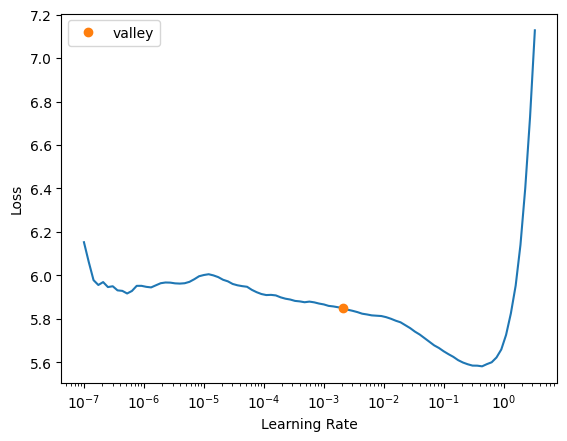

In [ ]:
lr = lm_learner.lr_find()
lr

Next, we train the model for one epoch. By default, aside from the final layers, other inner layers of the model are $frozen$. In other words, the pre-trained language model is kept intact, in essence this is **transfer learning**.

In [ ]:
lm_learner.fit_one_cycle(1, lr[0])

epoch,train_loss,valid_loss,perplexity,time
0,4.612034,4.178260,65.252235,03:22


Save language model state after 1 epoch.

In [ ]:
lm_learner.save('1epoch')

Path('models/1epoch.pth')

Next, we unfreeze all layers of model for futher tuning.

In [ ]:
lm_learner.unfreeze()

As before, find the optimal learning rate.

SuggestedLRs(valley=0.0004786300996784121)

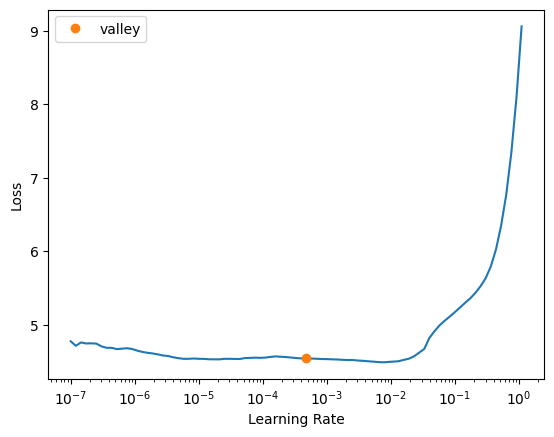

In [ ]:
lr = lm_learner.lr_find()
lr

Train model for 5 epochs.

In [ ]:
lm_learner.fit_one_cycle(5, lr[0])

epoch,train_loss,valid_loss,perplexity,time
0,4.121212,3.781269,43.871693,03:32
1,3.665559,3.419082,30.541378,03:39
2,3.515548,3.204425,24.641323,03:39
3,3.337457,3.105666,22.324076,03:34
4,3.306255,3.086282,21.895514,03:36


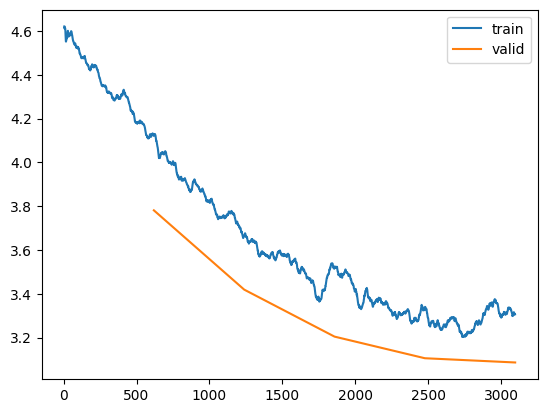

In [ ]:
lm_learner.recorder.plot_loss()

Save fully tuned model.

In [ ]:
lm_learner.save_encoder('finetuned')

Now we use the new LLM to build a email classifier. 

Create DataLoaders for classification using the cutomized language model. Notice, we set $is\_lm=False$ and use the vocabulary list from the LLM by setting $vocab=dls\_lm.vocab$.

In [ ]:
dls_cls = DataBlock(
            blocks=(TextBlock.from_df(text_cols=('text'), 
                              is_lm=False, 
                              vocab=dls_lm.vocab), 
            CategoryBlock),
            get_x=ColReader('text'),
            get_y=ColReader('category'), 
            splitter=RandomSplitter(valid_pct=0.2, seed=12345)
            ).dataloaders(df, bs=64)

In [ ]:
dls_cls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart _ xxrep 3 0 _ xxrep 3 0 2_01c228ca.593b5280content - type : text / plain ; \t xxunk - xxunk - transfer - encoding : xxunk < xxunk xxrep 3 $ xxunk ! # xxunk ! # xxunk % / % xxunk , xxunk ! $ xxunk % / $ xxunk xxrep 3 $ xxunk , xxunk ! # xxunk : xxunk $ xxunk # ! xxunk xxrep 3 $ xxup xxunk / $ @$5$$ ! # ! xxunk / ! xxunk > xxunk $ / $ * 4j xxrep 5 $ ? $ 7$^$9 ! # xxunk xxrep 38 - + xxunk \ xxunk # % "" xxunk \ % xxunk # % xxunk ! e = xxunk xxunk - mail : xxunk : 03 - 3518 - xxunk",ham
1,"xxbos > a world where some live in comfort and plenty , while half of the human > race lives on less than $ 2 a day , is neither just nor xxunk correct . xxmaj perhaps the most fundamental thing to realize about life on xxmaj earth xxunk following is a fascinating document of official xxmaj government policy that bears close reading . xxmaj it is the aspirations of a wonderful nation in an imperfect world . > xxmaj the war on terrorism is not a clash of civilizations . xxmaj it does , > however , reveal the clash inside a civilization , a battle for the > future of the xxmaj muslim world . xxmaj this is a struggle of ideas and this is an > area where xxmaj america must xxunk was recently at a lecture about the surprising success of xxmaj radio xxmaj sawa ,",ham
2,"xxbos xxrep 3 - xxunk - type : text / plain ; charset = iso-8859 - 1your xxmaj membership xxmaj community & xxmaj commentary ( june 29 , 2001)it 's xxmaj all xxmaj about xxmaj making moneyinformation to provide you with the absolute best low and no cost ways of providing traffic to your site , helping you to capitalize on the power and potential the web brings to every net - preneur . xxrep 3 - xxmaj this xxmaj issue xxmaj contains xxmaj sites xxmaj who xxmaj will xxmaj trade xxmaj links xxmaj with xxmaj you ! xxrep 3 - xxrep 13 - xxup in xxup this xxup issue xxrep 13 - 32 xxmaj easy xxmaj ways xxmaj to xxmaj breath xxmaj new xxmaj life xxmaj into xxmaj any xxunk xxunk xxmaj you xxmaj ready xxmaj for xxmaj your 15 xxmaj minutes of xxunk a xxup free xxmaj ad",spam


Create text classification learner and use the LLM as the encoder.

In [ ]:
learn = text_classifier_learner(dls_cls, 
                                AWD_LSTM, 
                                drop_mult=0.5, 
                                metrics=[accuracy, Precision(), Recall(), F1Score()])
learn = learn.load_encoder('finetuned')

Find the optimal learning rate.

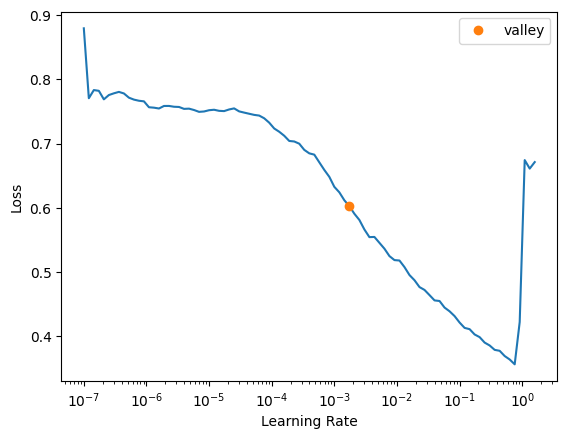

In [ ]:
lr = learn.lr_find()

And tune the model for 3 epochs.

In [ ]:
learn.fine_tune(3, lr[0])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.206832,0.122226,0.962893,0.933464,0.950199,0.941757,01:01


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.110422,0.192555,0.951572,0.922465,0.924303,0.923383,01:57
1,0.090761,0.051115,0.979874,0.955426,0.982072,0.968566,01:58
2,0.064141,0.054943,0.983019,0.961165,0.986056,0.973451,01:57


The metrics look great, and the confusion matrix shows this ULMFit model has indeed performed better than the off-the-shelf model. For example, the original classifier had 13 false negatives (actual spam emails classified as ham), the new model has just 7.

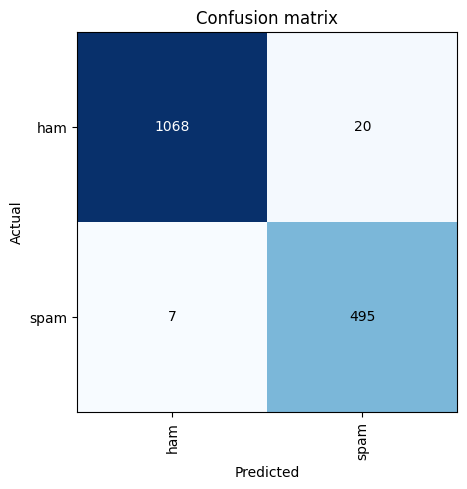

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Finally, let's use the LLM to generate text. Text generation involves prompting with some text and asking the model to generate additional text.

In [ ]:
# TEXT = "Free promotion"
# N_WORDS = 40
# N_SENTENCES = 5
# preds = [lm_learner.predict(TEXT, N_WORDS, temperature=0.75)
# for _ in range(N_SENTENCES)]
# print("\n".join(preds))
N_WORDS = 40

PROMPTS = ["We produce and distribute various motorcycle and car parts that", 
           "We are offering huge discount this weekend on ", 
           "I would like to tell you about the tets I ran on"]

preds = [lm_learner.predict(p, N_WORDS, temperature=0.75) for p in PROMPTS]

for idx in range(len(PROMPTS)):
  print(PROMPTS[idx], ': ', preds[idx])

We produce and distribute various motorcycle and car parts that :  We produce and distribute various motorcycle and car parts that can always be used to support the truck , truck , or SUV . We also provide the fuel for the truck ; trucks use our truck for an extended trip . We also provide the most
We are offering huge discount this weekend on  :  We are offering huge discount this weekend on the internet for only $ 14.95 per month ! Only $ 14.95 per month from our website is limited ! We offer the most targeted email services here . There are over 400 million mailing lists that
I would like to tell you about the tets I ran on :  i would like to tell you about the xxunk i ran on my Windows , but i never had to think Nmh is a word . Instead , i use the ALSA rpm on easier stuff to do . i found this an error in my log first


We see the LLM is capable of text generation. Although not very sophisticated, keep in mind that the model was trained with a very small domain specific dataset.

Generative LLMs are transforming the technology and business landscape. And the transformer architecture is democratizing machine learning by enabling innovation at a fraction of the cost of building LLMs from scratch.